# Sourcing & analyzing time-series data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [6]:
# Configure API key 

quandl.ApiConfig.api_key = 'jZPbKat-C7z_KitH9oey'

In [7]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/NROU')

In [8]:
data.head(5)

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [9]:
data.shape

(332, 1)

In [10]:
data.columns

Index(['Value'], dtype='object')

In [11]:
type(data)

pandas.core.frame.DataFrame

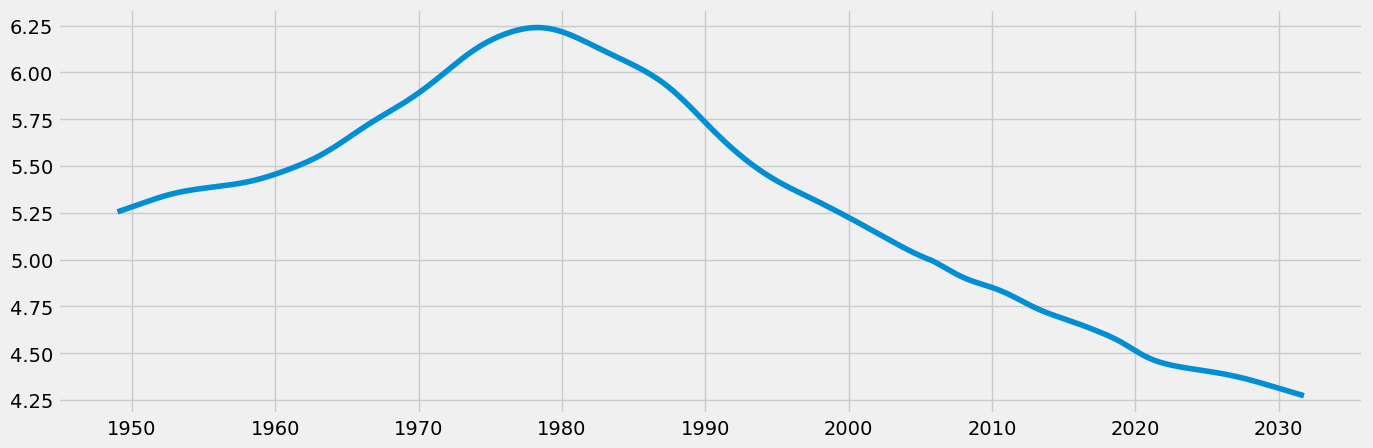

In [12]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 2. Subsetting, wrangling, and cleaning time-series data

In [13]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [14]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [15]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01') & (data_2['Date'] < '2020-06-01')]

In [16]:
data_sub.shape

(82, 2)

In [17]:
data_sub.head()

,Date,Value
204,2000-01-01,5.224948
205,2000-04-01,5.214622
206,2000-07-01,5.204211
207,2000-10-01,5.193731
208,2001-01-01,5.183197


In [18]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2000-01-01,5.224948
2000-04-01,5.214622
2000-07-01,5.204211
2000-10-01,5.193731
2001-01-01,5.183197


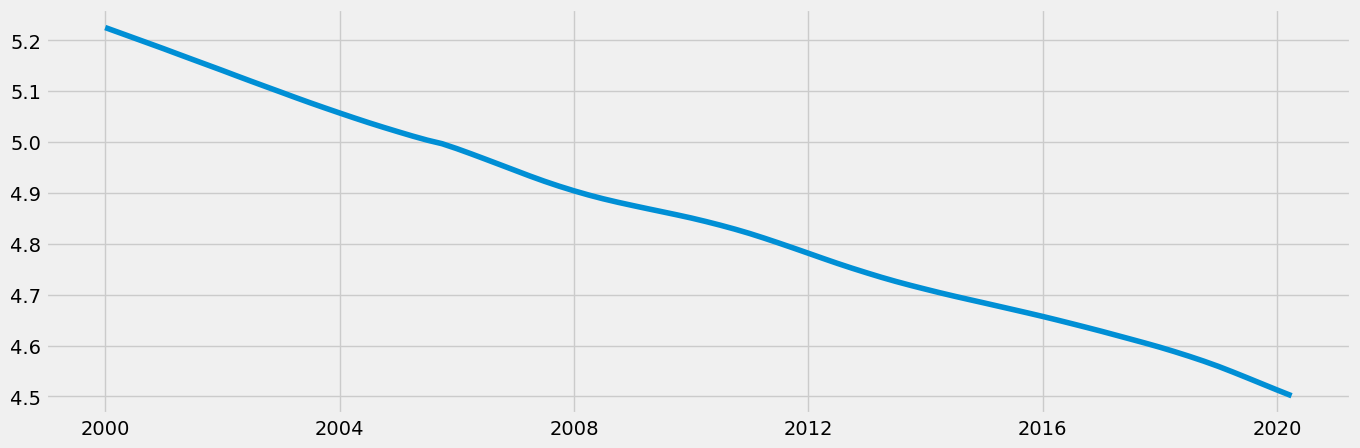

In [19]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [20]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [21]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### 3. Time-series analysis: decomposition

In [22]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [23]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

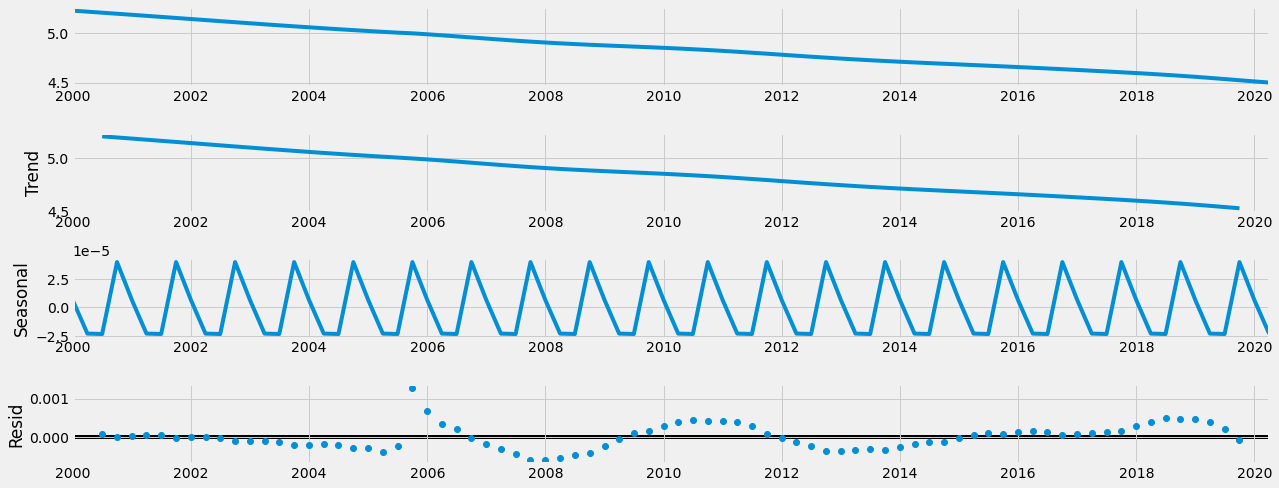

In [24]:
# Plot the separate components

decomposition.plot()
plt.show()

### 4. Testing for stationarity

In [25]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.169108
p-value                         0.686742
Number of Lags Used             4.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


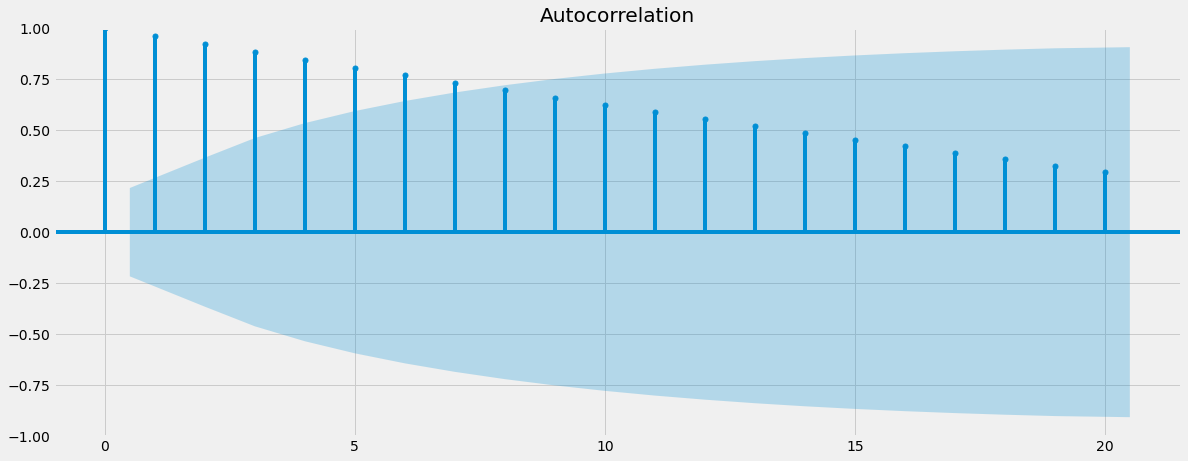

In [26]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### 5. Stationarizing the Federal Reserve Economic Data

In [27]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [28]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [29]:
data_diff.head()

,Value
datetime,
2000-04-01,-0.010326
2000-07-01,-0.010411
2000-10-01,-0.010480
2001-01-01,-0.010534
2001-04-01,-0.010583


In [30]:
data_diff.columns

Index(['Value'], dtype='object')

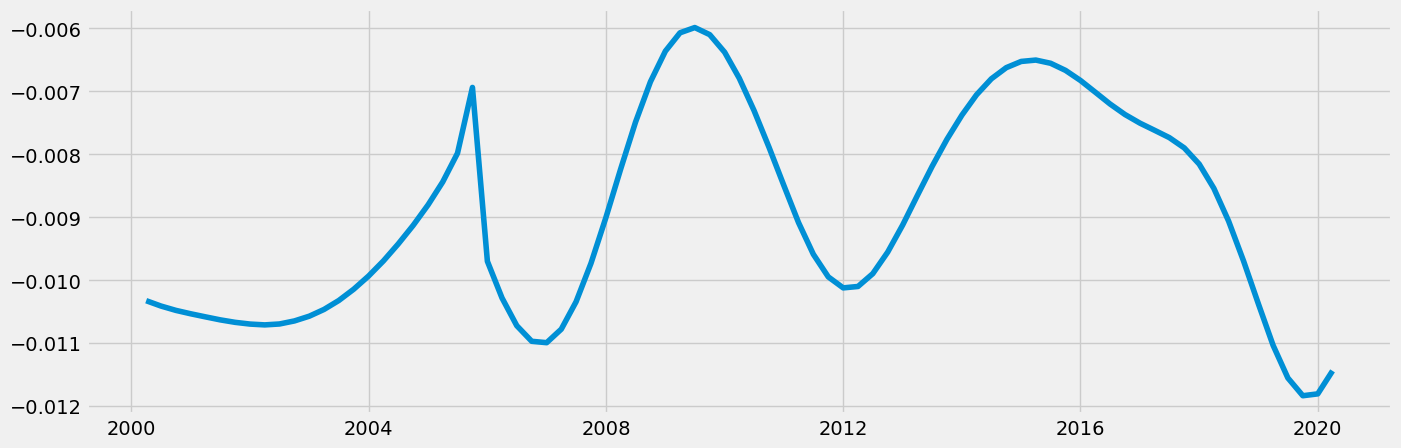

In [31]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [32]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.325195
p-value                         0.013789
Number of Lags Used             3.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


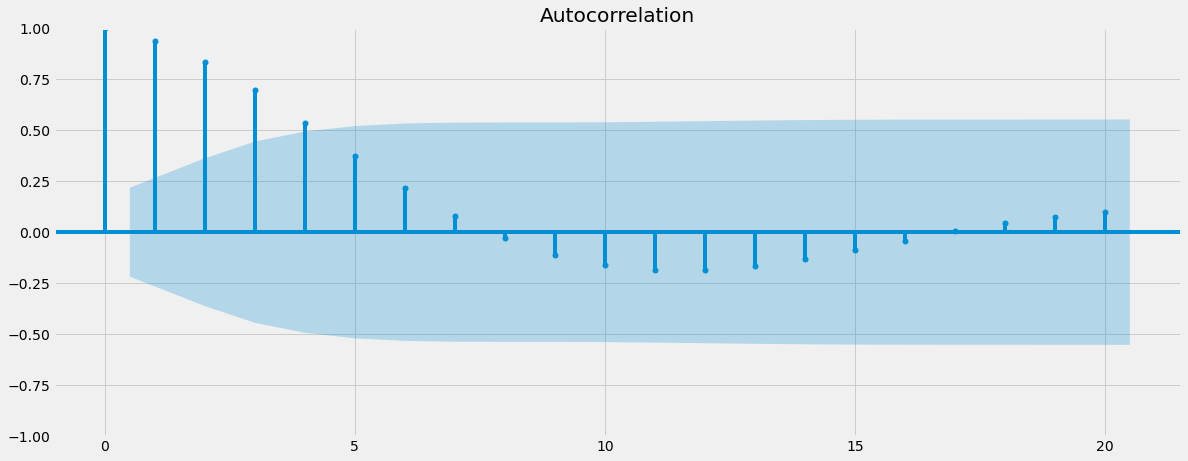

In [33]:
plot_acf(data_diff)
plt.show()